In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import time
import os

import warnings
warnings.filterwarnings('ignore')

import utils

import optuna
import lightgbm as lgb

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

In [2]:
feats_folder = '../data/processed/feature_level'
df_dataset = utils.read_pickles(feats_folder)

100%|██████████| 3/3 [00:00<00:00, 15.22it/s]


In [4]:
target = df_dataset.pop('target')

## Drop id columns

In [20]:
df_dataset.drop(['order_id','MODE(items.product_id)', 'MODE(items.seller_id)'], axis=1, inplace=True)

## Trian test split

In [21]:
x_train, x_test, y_train, y_test = train_test_split(df_dataset, target, test_size=0.33, random_state=42)

In [ ]:
## function for optuna

In [15]:
def model_lgb(params, cv_x, cv_y, fold_n = 3 ):

    folds = KFold(n_splits=fold_n, shuffle=True, random_state=30)
    oof = np.zeros(len(cv_x))
    features = list(cv_x.columns)

    for fold_, (train_index, valid_index) in enumerate(folds.split(cv_x, cv_y)):
        print('Fold', fold_, 'started at', time.ctime())
        X_train, X_valid = cv_x.iloc[train_index][features], cv_x.iloc[valid_index][features]
        Y_train, Y_valid = cv_y.iloc[train_index], cv_y.iloc[valid_index]

        train_data = lgb.Dataset(X_train, label=Y_train)
        valid_data = lgb.Dataset(X_valid, label=Y_valid)

        lgb_model = lgb.train(params, train_data, valid_sets = [train_data, valid_data],
                               verbose_eval = 1000, early_stopping_rounds = 100)

        oof[valid_index] = lgb_model.predict(cv_x.iloc[valid_index][features],
                                             num_iteration = lgb_model.best_iteration)
    return mean_squared_error(cv_y, oof)


In [23]:
def objective(trial):
    
    param = { 
                'max_depth':          trial.suggest_int('max_depth', 1, 30),
                "subsample" :         trial.suggest_loguniform('subsample', 0.0001, 1),
                "colsample_bytree" :  trial.suggest_loguniform('colsample_bytree', 0.0001, 1),
                "reg_lambda" :        trial.suggest_loguniform('reg_lambda', 1, 40),
                "n_estimators" :      trial.suggest_int('n_estimators', 50, 2000),
                'learning_rate':      trial.suggest_loguniform('learning_rate', 0.0001, 0.3),
                'min_data_in_leaf':   trial.suggest_int('min_data_in_leaf', 1, 50),
                "metric": 'rmse',            
                "verbosity": -1,
                'random_state' : 0,
                "num_threads" :4,
                'is_unbalance': True,
                'objective':'regression',
                "boosting":"gbdt"        
                }

    res = model_lgb(param, x_train, y_train, 3)
    return res

In [24]:
study = optuna.create_study()

In [25]:
start = time.time()
study.optimize(objective, n_trials = 20)

print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')

trial = study.best_trial

print('Value: {}'.format(trial.value))
print('Params: ')

for key, value in trial.params.items():
    print('{}: {}'.format(key, value))

finish = time.time()

print("time taken:",(finish-start)/60)

Fold 0 started at Sat May  4 18:09:17 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 58.1382	valid_1's rmse: 103.28
Did not meet early stopping. Best iteration is:
[1402]	training's rmse: 55.3577	valid_1's rmse: 101.868
Fold 1 started at Sat May  4 18:09:20 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 70.613	valid_1's rmse: 54.4052
Did not meet early stopping. Best iteration is:
[1402]	training's rmse: 68.1313	valid_1's rmse: 52.3947
Fold 2 started at Sat May  4 18:09:24 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 71.7608	valid_1's rmse: 51.1318
Did not meet early stopping. Best iteration is:
[1402]	training's rmse: 69.294	valid_1's rmse: 47.9688
Fold 3 started at Sat May  4 18:09:30 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 67.3646	valid_1's rmse: 73.8379
Did not meet early stopping. Best iteration

[I 2019-05-04 18:09:45,436] Finished trial#0 resulted in value: 4794.858154036771. Current best value is 4794.858154036771 with parameters: {'max_depth': 2, 'subsample': 0.0008717997710858924, 'colsample_bytree': 0.00032330424624794365, 'reg_lambda': 7.255846322982719, 'n_estimators': 1402, 'learning_rate': 0.019893215025099907, 'min_data_in_leaf': 5}.


Fold 0 started at Sat May  4 18:09:45 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 217.439	valid_1's rmse: 229.163
Did not meet early stopping. Best iteration is:
[1832]	training's rmse: 212.339	valid_1's rmse: 224.585
Fold 1 started at Sat May  4 18:10:04 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 221.136	valid_1's rmse: 214.369
Did not meet early stopping. Best iteration is:
[1832]	training's rmse: 216.172	valid_1's rmse: 209.132
Fold 2 started at Sat May  4 18:10:23 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 220.978	valid_1's rmse: 215.235
Did not meet early stopping. Best iteration is:
[1832]	training's rmse: 216.027	valid_1's rmse: 210.126
Fold 3 started at Sat May  4 18:14:42 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 218.779	valid_1's rmse: 224.114
Did not meet early stopping. Best iterat

[I 2019-05-04 18:15:15,198] Finished trial#1 resulted in value: 46178.15598557276. Current best value is 4794.858154036771 with parameters: {'max_depth': 2, 'subsample': 0.0008717997710858924, 'colsample_bytree': 0.00032330424624794365, 'reg_lambda': 7.255846322982719, 'n_estimators': 1402, 'learning_rate': 0.019893215025099907, 'min_data_in_leaf': 5}.


Fold 0 started at Sat May  4 18:15:15 2019
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 210.983	valid_1's rmse: 223.477
Fold 1 started at Sat May  4 18:15:21 2019
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 214.841	valid_1's rmse: 207.743
Fold 2 started at Sat May  4 18:15:26 2019
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 214.68	valid_1's rmse: 208.848
Fold 3 started at Sat May  4 18:15:31 2019
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 212.484	valid_1's rmse: 217.824
Fold 4 started at Sat May  4 18:15:36 2019
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[400]	train

[I 2019-05-04 18:15:41,482] Finished trial#2 resulted in value: 45628.75650232704. Current best value is 4794.858154036771 with parameters: {'max_depth': 2, 'subsample': 0.0008717997710858924, 'colsample_bytree': 0.00032330424624794365, 'reg_lambda': 7.255846322982719, 'n_estimators': 1402, 'learning_rate': 0.019893215025099907, 'min_data_in_leaf': 5}.


Fold 0 started at Sat May  4 18:15:41 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 64.3952	valid_1's rmse: 107.098
Did not meet early stopping. Best iteration is:
[1407]	training's rmse: 58.7312	valid_1's rmse: 103.809
Fold 1 started at Sat May  4 18:15:46 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 77.4273	valid_1's rmse: 59.7627
Did not meet early stopping. Best iteration is:
[1407]	training's rmse: 72.7166	valid_1's rmse: 55.2479
Fold 2 started at Sat May  4 18:15:50 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 78.3866	valid_1's rmse: 58.0198
Did not meet early stopping. Best iteration is:
[1407]	training's rmse: 73.7602	valid_1's rmse: 51.5575
Fold 3 started at Sat May  4 18:15:55 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 74.8047	valid_1's rmse: 77.4529
Did not meet early stopping. Best iterat

[I 2019-05-04 18:16:05,281] Finished trial#3 resulted in value: 5095.393751541782. Current best value is 4794.858154036771 with parameters: {'max_depth': 2, 'subsample': 0.0008717997710858924, 'colsample_bytree': 0.00032330424624794365, 'reg_lambda': 7.255846322982719, 'n_estimators': 1402, 'learning_rate': 0.019893215025099907, 'min_data_in_leaf': 5}.


Fold 0 started at Sat May  4 18:16:05 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 113.085	valid_1's rmse: 141.134
Did not meet early stopping. Best iteration is:
[1917]	training's rmse: 71.6268	valid_1's rmse: 111.905
Fold 1 started at Sat May  4 18:16:46 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 121.277	valid_1's rmse: 106.33
Did not meet early stopping. Best iteration is:
[1917]	training's rmse: 83.3391	valid_1's rmse: 65.0828
Fold 2 started at Sat May  4 18:17:32 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 121.768	valid_1's rmse: 109.23
Did not meet early stopping. Best iteration is:
[1917]	training's rmse: 84.103	valid_1's rmse: 66.8442
Fold 3 started at Sat May  4 18:18:16 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 118.967	valid_1's rmse: 122.824
Did not meet early stopping. Best iteration

[I 2019-05-04 18:19:32,685] Finished trial#4 resulted in value: 6771.737926355323. Current best value is 4794.858154036771 with parameters: {'max_depth': 2, 'subsample': 0.0008717997710858924, 'colsample_bytree': 0.00032330424624794365, 'reg_lambda': 7.255846322982719, 'n_estimators': 1402, 'learning_rate': 0.019893215025099907, 'min_data_in_leaf': 5}.


Fold 0 started at Sat May  4 18:19:32 2019
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[663]	training's rmse: 49.7931	valid_1's rmse: 100.103
Fold 1 started at Sat May  4 18:19:38 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[221]	training's rmse: 64.7759	valid_1's rmse: 52.8595
Fold 2 started at Sat May  4 18:19:43 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[221]	training's rmse: 65.682	valid_1's rmse: 48.9605
Fold 3 started at Sat May  4 18:19:46 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[218]	training's rmse: 62.3593	valid_1's rmse: 68.05
Fold 4 started at Sat May  4 18:19:50 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[343]	training's rmse: 62.1852	valid_1's rmse: 57.3645


[I 2019-05-04 18:19:54,846] Finished trial#5 resulted in value: 4626.675860967911. Current best value is 4626.675860967911 with parameters: {'max_depth': 15, 'subsample': 0.014656474645642736, 'colsample_bytree': 0.0022327205406746957, 'reg_lambda': 5.296089599945313, 'n_estimators': 663, 'learning_rate': 0.24291425772173952, 'min_data_in_leaf': 27}.


Fold 0 started at Sat May  4 18:19:54 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 187.598	valid_1's rmse: 202.585
Did not meet early stopping. Best iteration is:
[1230]	training's rmse: 180.89	valid_1's rmse: 196.723
Fold 1 started at Sat May  4 18:20:05 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 191.86	valid_1's rmse: 183.743
Did not meet early stopping. Best iteration is:
[1230]	training's rmse: 185.311	valid_1's rmse: 176.869
Fold 2 started at Sat May  4 18:20:18 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 191.769	valid_1's rmse: 185.349
Did not meet early stopping. Best iteration is:
[1230]	training's rmse: 185.235	valid_1's rmse: 178.635
Fold 3 started at Sat May  4 18:20:28 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 189.471	valid_1's rmse: 195.011
Did not meet early stopping. Best iteratio

[I 2019-05-04 18:20:47,293] Finished trial#6 resulted in value: 33996.20437645029. Current best value is 4626.675860967911 with parameters: {'max_depth': 15, 'subsample': 0.014656474645642736, 'colsample_bytree': 0.0022327205406746957, 'reg_lambda': 5.296089599945313, 'n_estimators': 663, 'learning_rate': 0.24291425772173952, 'min_data_in_leaf': 27}.


Fold 0 started at Sat May  4 18:20:47 2019
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[917]	training's rmse: 204.218	valid_1's rmse: 217.464
Fold 1 started at Sat May  4 18:20:59 2019
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[917]	training's rmse: 208.222	valid_1's rmse: 200.795
Fold 2 started at Sat May  4 18:21:10 2019
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[917]	training's rmse: 208.085	valid_1's rmse: 202.023
Fold 3 started at Sat May  4 18:21:22 2019
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[917]	training's rmse: 205.865	valid_1's rmse: 211.217
Fold 4 started at Sat May  4 18:21:34 2019
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[917]	trai

[I 2019-05-04 18:21:45,260] Finished trial#7 resulted in value: 42855.47470901608. Current best value is 4626.675860967911 with parameters: {'max_depth': 15, 'subsample': 0.014656474645642736, 'colsample_bytree': 0.0022327205406746957, 'reg_lambda': 5.296089599945313, 'n_estimators': 663, 'learning_rate': 0.24291425772173952, 'min_data_in_leaf': 27}.


Fold 0 started at Sat May  4 18:21:45 2019
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[71]	training's rmse: 180.637	valid_1's rmse: 196.993
Fold 1 started at Sat May  4 18:21:47 2019
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[71]	training's rmse: 185.091	valid_1's rmse: 176.763
Fold 2 started at Sat May  4 18:21:49 2019
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[71]	training's rmse: 184.987	valid_1's rmse: 178.748
Fold 3 started at Sat May  4 18:21:51 2019
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[71]	training's rmse: 182.758	valid_1's rmse: 188.328
Fold 4 started at Sat May  4 18:21:53 2019
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[71]	training'

[I 2019-05-04 18:21:56,145] Finished trial#8 resulted in value: 34009.870974566395. Current best value is 4626.675860967911 with parameters: {'max_depth': 15, 'subsample': 0.014656474645642736, 'colsample_bytree': 0.0022327205406746957, 'reg_lambda': 5.296089599945313, 'n_estimators': 663, 'learning_rate': 0.24291425772173952, 'min_data_in_leaf': 27}.


Fold 0 started at Sat May  4 18:21:56 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 29.8913	valid_1's rmse: 94.0531
Did not meet early stopping. Best iteration is:
[1942]	training's rmse: 19.1917	valid_1's rmse: 91.0378
Fold 1 started at Sat May  4 18:22:29 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[602]	training's rmse: 53.0446	valid_1's rmse: 46.4382
Fold 2 started at Sat May  4 18:22:44 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[819]	training's rmse: 48.9954	valid_1's rmse: 43.7433
Fold 3 started at Sat May  4 18:23:06 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[594]	training's rmse: 51.6797	valid_1's rmse: 65.6109
Fold 4 started at Sat May  4 18:23:23 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[811]

[I 2019-05-04 18:23:42,687] Finished trial#9 resulted in value: 3830.478552591553. Current best value is 3830.478552591553 with parameters: {'max_depth': 17, 'subsample': 0.47222612110523327, 'colsample_bytree': 0.24624414445553958, 'reg_lambda': 3.287121000996276, 'n_estimators': 1942, 'learning_rate': 0.006696272560649142, 'min_data_in_leaf': 17}.


Fold 0 started at Sat May  4 18:23:42 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 13.3476	valid_1's rmse: 86.5056
Did not meet early stopping. Best iteration is:
[1748]	training's rmse: 7.00425	valid_1's rmse: 84.7895
Fold 1 started at Sat May  4 18:24:40 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[52]	training's rmse: 62.0445	valid_1's rmse: 46.9117
Fold 2 started at Sat May  4 18:24:46 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	training's rmse: 63.3704	valid_1's rmse: 42.0903
Fold 3 started at Sat May  4 18:24:55 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[258]	training's rmse: 46.659	valid_1's rmse: 63.5044
Fold 4 started at Sat May  4 18:25:12 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[42]	tra

[I 2019-05-04 18:25:23,617] Finished trial#10 resulted in value: 3590.631558749682. Current best value is 3590.631558749682 with parameters: {'max_depth': 28, 'subsample': 0.7761465640224046, 'colsample_bytree': 0.8060445205222828, 'reg_lambda': 32.00456948327807, 'n_estimators': 1748, 'learning_rate': 0.10637827542229136, 'min_data_in_leaf': 50}.


Fold 0 started at Sat May  4 18:25:23 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 4.64508	valid_1's rmse: 84.8648
Did not meet early stopping. Best iteration is:
[1641]	training's rmse: 1.83036	valid_1's rmse: 84.0804
Fold 1 started at Sat May  4 18:26:19 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[14]	training's rmse: 66.1035	valid_1's rmse: 47.7644
Fold 2 started at Sat May  4 18:26:27 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 63.8988	valid_1's rmse: 41.0695
Fold 3 started at Sat May  4 18:26:35 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[63]	training's rmse: 53.1749	valid_1's rmse: 63.7224
Fold 4 started at Sat May  4 18:26:45 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[25]	tra

[I 2019-05-04 18:26:52,537] Finished trial#11 resulted in value: 3565.7500534001188. Current best value is 3565.7500534001188 with parameters: {'max_depth': 30, 'subsample': 0.8035235591094531, 'colsample_bytree': 0.8321132479695705, 'reg_lambda': 35.28948491558843, 'n_estimators': 1641, 'learning_rate': 0.23519972138142264, 'min_data_in_leaf': 49}.


Fold 0 started at Sat May  4 18:26:52 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 17.4549	valid_1's rmse: 89.9418
Did not meet early stopping. Best iteration is:
[1554]	training's rmse: 11.9114	valid_1's rmse: 87.6667
Fold 1 started at Sat May  4 18:28:03 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[87]	training's rmse: 61.4206	valid_1's rmse: 47.0035
Fold 2 started at Sat May  4 18:28:12 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[86]	training's rmse: 62.5368	valid_1's rmse: 42.1612
Fold 3 started at Sat May  4 18:28:21 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[266]	training's rmse: 50.7752	valid_1's rmse: 63.8682
Fold 4 started at Sat May  4 18:28:39 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[144]	t

[I 2019-05-04 18:28:53,367] Finished trial#12 resulted in value: 3696.917029414797. Current best value is 3565.7500534001188 with parameters: {'max_depth': 30, 'subsample': 0.8035235591094531, 'colsample_bytree': 0.8321132479695705, 'reg_lambda': 35.28948491558843, 'n_estimators': 1641, 'learning_rate': 0.23519972138142264, 'min_data_in_leaf': 49}.


Fold 0 started at Sat May  4 18:28:53 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 22.0865	valid_1's rmse: 89.0747
Did not meet early stopping. Best iteration is:
[1006]	training's rmse: 21.9816	valid_1's rmse: 89.0414
Fold 1 started at Sat May  4 18:29:08 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[80]	training's rmse: 64.8396	valid_1's rmse: 48.5311
Fold 2 started at Sat May  4 18:29:13 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[114]	training's rmse: 62.4964	valid_1's rmse: 43.628
Fold 3 started at Sat May  4 18:29:18 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[332]	training's rmse: 51.1551	valid_1's rmse: 64.4114
Fold 4 started at Sat May  4 18:29:26 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[155]	t

[I 2019-05-04 18:29:32,365] Finished trial#13 resulted in value: 3824.095562224567. Current best value is 3565.7500534001188 with parameters: {'max_depth': 30, 'subsample': 0.8035235591094531, 'colsample_bytree': 0.8321132479695705, 'reg_lambda': 35.28948491558843, 'n_estimators': 1641, 'learning_rate': 0.23519972138142264, 'min_data_in_leaf': 49}.


Fold 0 started at Sat May  4 18:29:32 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 48.6531	valid_1's rmse: 99.9529
Did not meet early stopping. Best iteration is:
[1576]	training's rmse: 47.4101	valid_1's rmse: 99.4929
Fold 1 started at Sat May  4 18:29:47 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[245]	training's rmse: 64.9056	valid_1's rmse: 51.9794
Fold 2 started at Sat May  4 18:29:52 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[205]	training's rmse: 66.3281	valid_1's rmse: 48.8341
Fold 3 started at Sat May  4 18:29:57 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[218]	training's rmse: 62.7512	valid_1's rmse: 67.8381
Fold 4 started at Sat May  4 18:30:01 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[379]

[I 2019-05-04 18:30:06,928] Finished trial#14 resulted in value: 4575.972708379004. Current best value is 3565.7500534001188 with parameters: {'max_depth': 30, 'subsample': 0.8035235591094531, 'colsample_bytree': 0.8321132479695705, 'reg_lambda': 35.28948491558843, 'n_estimators': 1641, 'learning_rate': 0.23519972138142264, 'min_data_in_leaf': 49}.


Fold 0 started at Sat May  4 18:30:06 2019
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[674]	training's rmse: 110.638	valid_1's rmse: 139.271
Fold 1 started at Sat May  4 18:30:17 2019
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[674]	training's rmse: 119.012	valid_1's rmse: 103.638
Fold 2 started at Sat May  4 18:30:27 2019
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[674]	training's rmse: 119.324	valid_1's rmse: 106.894
Fold 3 started at Sat May  4 18:30:38 2019
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[674]	training's rmse: 116.654	valid_1's rmse: 120.892
Fold 4 started at Sat May  4 18:30:48 2019
Training until validation scores don't improve for 100 rounds.
Did not meet early stopping. Best iteration is:
[674]	trai

[I 2019-05-04 18:30:58,655] Finished trial#15 resulted in value: 13713.205370663787. Current best value is 3565.7500534001188 with parameters: {'max_depth': 30, 'subsample': 0.8035235591094531, 'colsample_bytree': 0.8321132479695705, 'reg_lambda': 35.28948491558843, 'n_estimators': 1641, 'learning_rate': 0.23519972138142264, 'min_data_in_leaf': 49}.


Fold 0 started at Sat May  4 18:30:58 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 146.543	valid_1's rmse: 167.502
Did not meet early stopping. Best iteration is:
[1212]	training's rmse: 136.453	valid_1's rmse: 159.226
Fold 1 started at Sat May  4 18:31:08 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 152.59	valid_1's rmse: 141.375
Did not meet early stopping. Best iteration is:
[1212]	training's rmse: 142.97	valid_1's rmse: 130.992
Fold 2 started at Sat May  4 18:31:19 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 152.569	valid_1's rmse: 143.926
Did not meet early stopping. Best iteration is:
[1212]	training's rmse: 142.994	valid_1's rmse: 133.734
Fold 3 started at Sat May  4 18:31:30 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 150.063	valid_1's rmse: 155.349
Did not meet early stopping. Best iteratio

[I 2019-05-04 18:31:55,075] Finished trial#16 resulted in value: 20085.2857465901. Current best value is 3565.7500534001188 with parameters: {'max_depth': 30, 'subsample': 0.8035235591094531, 'colsample_bytree': 0.8321132479695705, 'reg_lambda': 35.28948491558843, 'n_estimators': 1641, 'learning_rate': 0.23519972138142264, 'min_data_in_leaf': 49}.


Fold 0 started at Sat May  4 18:31:55 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 13.5794	valid_1's rmse: 87.8501
Did not meet early stopping. Best iteration is:
[1730]	training's rmse: 7.42786	valid_1's rmse: 86.154
Fold 1 started at Sat May  4 18:33:36 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[36]	training's rmse: 64.9328	valid_1's rmse: 47.0866
Fold 2 started at Sat May  4 18:33:47 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[55]	training's rmse: 62.8548	valid_1's rmse: 41.8262
Fold 3 started at Sat May  4 18:34:01 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[204]	training's rmse: 49.7478	valid_1's rmse: 63.6054
Fold 4 started at Sat May  4 18:34:29 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[78]	tra

[I 2019-05-04 18:34:44,531] Finished trial#17 resulted in value: 3640.3172760712173. Current best value is 3565.7500534001188 with parameters: {'max_depth': 30, 'subsample': 0.8035235591094531, 'colsample_bytree': 0.8321132479695705, 'reg_lambda': 35.28948491558843, 'n_estimators': 1641, 'learning_rate': 0.23519972138142264, 'min_data_in_leaf': 49}.


Fold 0 started at Sat May  4 18:34:44 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.51463	valid_1's rmse: 85.4562
Did not meet early stopping. Best iteration is:
[1726]	training's rmse: 0.381207	valid_1's rmse: 85.0952
Fold 1 started at Sat May  4 18:36:25 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[30]	training's rmse: 58.4969	valid_1's rmse: 46.8791
Fold 2 started at Sat May  4 18:36:35 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[17]	training's rmse: 63.3083	valid_1's rmse: 42.5279
Fold 3 started at Sat May  4 18:36:42 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[57]	training's rmse: 50.9125	valid_1's rmse: 63.1483
Fold 4 started at Sat May  4 18:36:52 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	tr

[I 2019-05-04 18:37:01,452] Finished trial#18 resulted in value: 3590.324670226734. Current best value is 3565.7500534001188 with parameters: {'max_depth': 30, 'subsample': 0.8035235591094531, 'colsample_bytree': 0.8321132479695705, 'reg_lambda': 35.28948491558843, 'n_estimators': 1641, 'learning_rate': 0.23519972138142264, 'min_data_in_leaf': 49}.


Fold 0 started at Sat May  4 18:37:01 2019
Training until validation scores don't improve for 100 rounds.
[1000]	training's rmse: 1.68478	valid_1's rmse: 86.1656
Did not meet early stopping. Best iteration is:
[1585]	training's rmse: 0.571535	valid_1's rmse: 85.8125
Fold 1 started at Sat May  4 18:37:45 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[83]	training's rmse: 46.4615	valid_1's rmse: 47.471
Fold 2 started at Sat May  4 18:37:51 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 61.2954	valid_1's rmse: 42.7876
Fold 3 started at Sat May  4 18:37:57 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[19]	training's rmse: 59.39	valid_1's rmse: 64.5176
Fold 4 started at Sat May  4 18:38:04 2019
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[52]	train

[I 2019-05-04 18:38:13,521] Finished trial#19 resulted in value: 3674.7355174619665. Current best value is 3565.7500534001188 with parameters: {'max_depth': 30, 'subsample': 0.8035235591094531, 'colsample_bytree': 0.8321132479695705, 'reg_lambda': 35.28948491558843, 'n_estimators': 1641, 'learning_rate': 0.23519972138142264, 'min_data_in_leaf': 49}.


Number of finished trials: 20
Best trial:
Value: 3565.7500534001188
Params: 
max_depth: 30
subsample: 0.8035235591094531
colsample_bytree: 0.8321132479695705
reg_lambda: 35.28948491558843
n_estimators: 1641
learning_rate: 0.23519972138142264
min_data_in_leaf: 49
time taken: 28.940214518706004


## Final Model

In [27]:
# Optuna best features
# max_depth: 30
# subsample: 0.8035235591094531
# colsample_bytree: 0.8321132479695705
# reg_lambda: 35.28948491558843
# n_estimators: 1641
# learning_rate: 0.23519972138142264
# min_data_in_leaf: 49
param = { 
                'max_depth':   30,
                "subsample" :  0.8,
                "colsample_bytree" : 0.8,
                "reg_lambda" :   35,
                "n_estimators" :  1600,
                'learning_rate':  0.23,
                'min_data_in_leaf':   49,
                "metric": 'rmse',            
                "verbosity": -1,
                'random_state' : 0,
                "num_threads" :4,
                'is_unbalance': True,
                'objective':'regression',
                "boosting":"gbdt"        
                }



In [29]:
features = list(x_train.columns)

train_data = lgb.Dataset(x_train[features], y_train)
lgb_model = lgb.train(param, train_data, verbose_eval = 1000)

feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = features
feature_importance_df["importance"] = lgb_model.feature_importance()

## Save the model

In [30]:
lgb_model.save_model('../results/lgb_optuna.20_ft.6.2_115feats_5.4.txt')

## Performing on test set

In [33]:
y_pred = lgb_model.predict(x_test[features])
print(mean_squared_error(y_test, y_pred))

2983.939684554294


## Important features

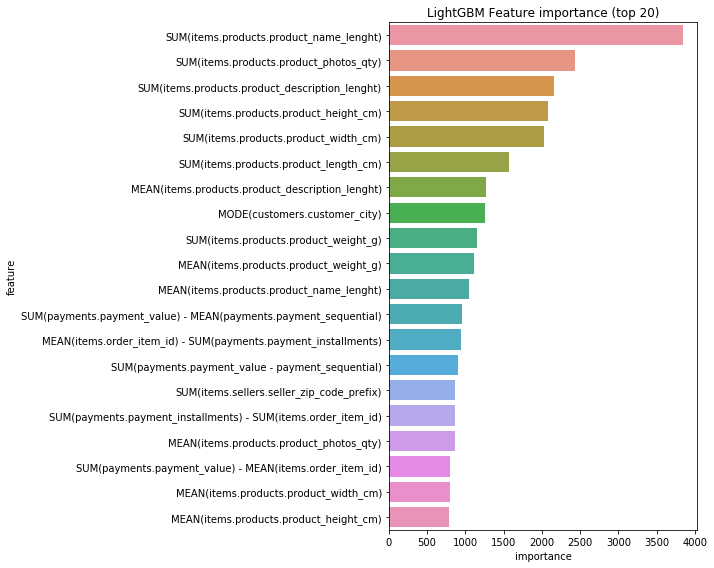

In [39]:
cols = (feature_importance_df.sort_values(by="importance", ascending=False)[:20]['feature'])
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(10,8))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Feature importance (top 20)')
plt.tight_layout()
plt.show()

In [49]:
outfile = open('../results/ft.6.2_115feats_5.4.txt', 'w')
outfile.write("\n".join(list(df_dataset.columns)))

6141